In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/corporacin-favorita-grocery-sales-forecasting/oil.csv
/kaggle/input/corporacin-favorita-grocery-sales-forecasting/items.csv
/kaggle/input/corporacin-favorita-grocery-sales-forecasting/sample_submission.csv
/kaggle/input/corporacin-favorita-grocery-sales-forecasting/holidays_events.csv
/kaggle/input/corporacin-favorita-grocery-sales-forecasting/stores.csv
/kaggle/input/corporacin-favorita-grocery-sales-forecasting/train.csv
/kaggle/input/corporacin-favorita-grocery-sales-forecasting/test.csv
/kaggle/input/corporacin-favorita-grocery-sales-forecasting/transactions.csv


Data pre-processing : ETL process

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [5]:
import warnings
warnings.filterwarnings("ignore")

from datetime import date, timedelta
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

from matplotlib import pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import os
import gc

****Chargement de l'ensemble de données****

Le jeu de données contient les enregistrements de ventes historiques de 10 magasins et 50 produits, de l'année 2013 à l'année 2017.

In [6]:
for file in os.listdir():
    if file[-3:]=='.7z':
        if os.path.exists(file[:-3]):
            print("="*50)
            print("'{}'Extracted File is Already Present".format(file[:-3]))
            
        elif file=='train.csv.7z':
            !p7zip -d 'train.csv.7z'
            print("="*50)
            print("'{}' File Extracted Successfully".format(file))

        elif file=='stores.csv.7z':
            !p7zip -d 'stores.csv.7z'
            print("="*50)
            print("'{}' File Extracted Successfully".format(file))

        elif file=='items.csv.7z':
            !p7zip -d 'items.csv.7z'
            print("="*50)
            print("'{}' File Extracted Successfully".format(file))

        elif file=='test.csv.7z':
            !p7zip -d 'test.csv.7z'
            print("="*50)
            print("'{}' File Extracted Successfully".format(file))

        print("="*50)

In [7]:
#Skipping rows from 1 to 101688780‬ i.e. reading 2017 data only.
df_train = pd.read_csv('/kaggle/input/corporacin-favorita-grocery-sales-forecasting/train.csv', dtype={'onpromotion': int}, parse_dates=["date"], skiprows=range(1,101688780))
print("Shape of Train Dataframe --> ",df_train.shape)
df_train.head()

Shape of Train Dataframe -->  (23808261, 6)


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,101688779,2017-01-01,25,99197,1.0,0
1,101688780,2017-01-01,25,103665,7.0,0
2,101688781,2017-01-01,25,105574,1.0,0
3,101688782,2017-01-01,25,105857,4.0,0
4,101688783,2017-01-01,25,106716,2.0,0


Dans le cadre de ce projet, nous n'examinerons que les ventes de l'article 1 du magasin 1. L'ensemble de données est divisé en ensembles de formation et de test, l'ensemble de formation contenant les enregistrements de ventes de janvier 2013 à septembre 2017 et l'ensemble de test (ensemble de validation) contenant les enregistrements de ventes des trois derniers mois de l'année 2017.

De nouvelles caractéristiques ont été créées à partir du champ de la date, à des fins d'analyse exploratoire des données et de modélisation causale.

In [8]:
print("No. of  Datapoints --> {}\n No. of Features --> {}".format(*df_train.shape))
df_train.head()

No. of  Datapoints --> 23808261
 No. of Features --> 6


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,101688779,2017-01-01,25,99197,1.0,0
1,101688780,2017-01-01,25,103665,7.0,0
2,101688781,2017-01-01,25,105574,1.0,0
3,101688782,2017-01-01,25,105857,4.0,0
4,101688783,2017-01-01,25,106716,2.0,0


In [9]:
#Dropping Id Column
df_train=df_train.drop('id',axis=1)
df_train.head()

,date,store_nbr,item_nbr,unit_sales,onpromotion
0,2017-01-01,25,99197,1.0,0
1,2017-01-01,25,103665,7.0,0
2,2017-01-01,25,105574,1.0,0
3,2017-01-01,25,105857,4.0,0
4,2017-01-01,25,106716,2.0,0


Caractéristiques :

Date
Numéro de magasin (nombres entiers représentant différents magasins)

Numéro d'article (nombres entiers représentant différents magasins)

En promotion (Caractéristique logique, indiquant si l'article vendu a bénéficié d'un prix promotionnel spécial à ce moment-là dans le magasin en question. Cette caractéristique contient de nombreuses valeurs NA).

Variable cible --> Ventes à l'unité (c'est-à-dire le nombre d'unités de l'article en question qui ont été vendues dans ce magasin ce jour-là. Les valeurs négatives signifient que cet article particulier a été retourné) Transformer la variable cible afin qu'elle corresponde mieux aux hypothèses sous-jacentes à la régression.

La transformation logarithmique a rendu les distributions fortement asymétriques moins asymétriques.

In [10]:
#Checking Missing values
def find_nan_values(df):
    if df.isnull().values.any():
        null_columns=df.columns[df.isnull().any()].tolist()
        for column in null_columns:
            total_values=df.shape[0]
            null_values=df[column].isnull().sum()
            print("No. of Nan Values in '{}' column --> {}".format(column,null_values))
            print("{:.2f} % of Total values".format((100 * null_values) / total_values))
            print("\n")
    else:
        print("No Column has Nan Values")
#Checking which columns have Nan values
find_nan_values(df_train)

No Column has Nan Values


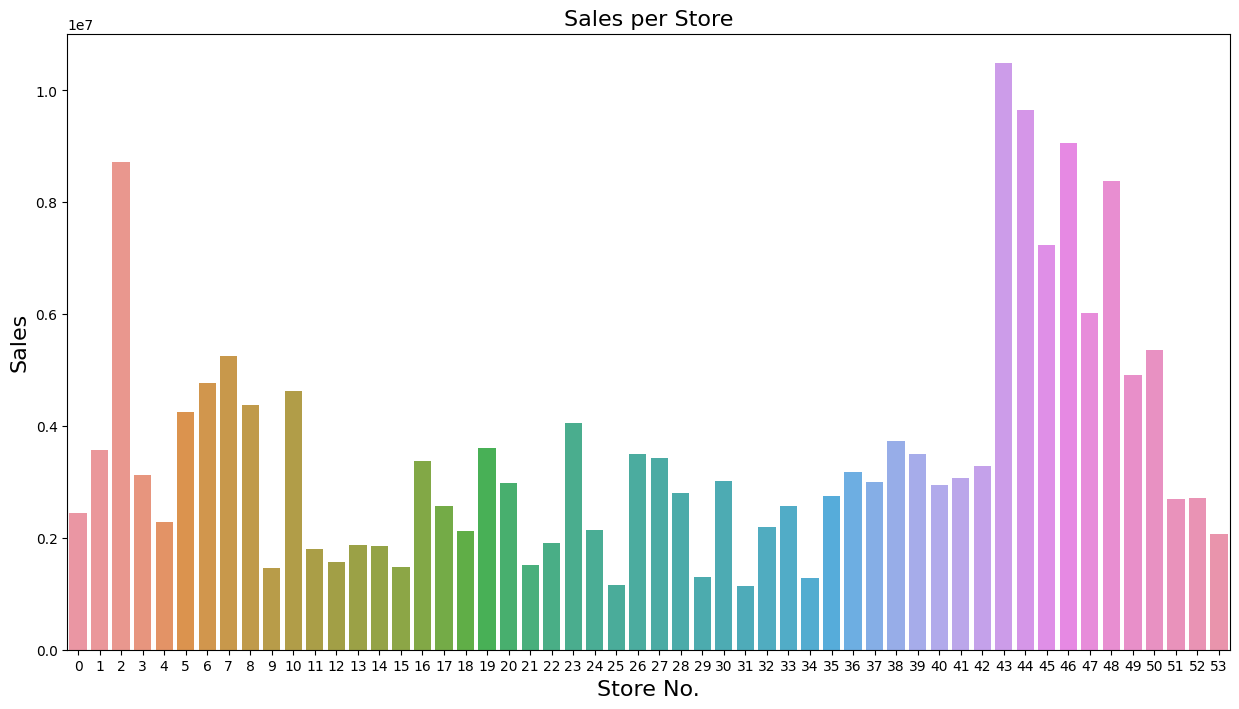

In [11]:
#Unit sales of Each Store
# Group By store_nbr and Sum of unit_sales for each store_nbr
x = df_train.groupby(['store_nbr'],as_index=False).agg({'unit_sales':'sum'}) 

#PLotting store_nbr Vs unit_sales
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax = sns.barplot(x = x.index, y= "unit_sales", data = x)
plt.title('Sales per Store',fontsize=16)
plt.ylabel('Sales',fontsize=16)
plt.xlabel('Store No.',fontsize=16)
plt.show()

Les numéros des magasins vont de 1 à 54.

Le magasin n° 44 a le chiffre d'affaires le plus élevé.

Le magasin n° 52 a les ventes les plus faibles.

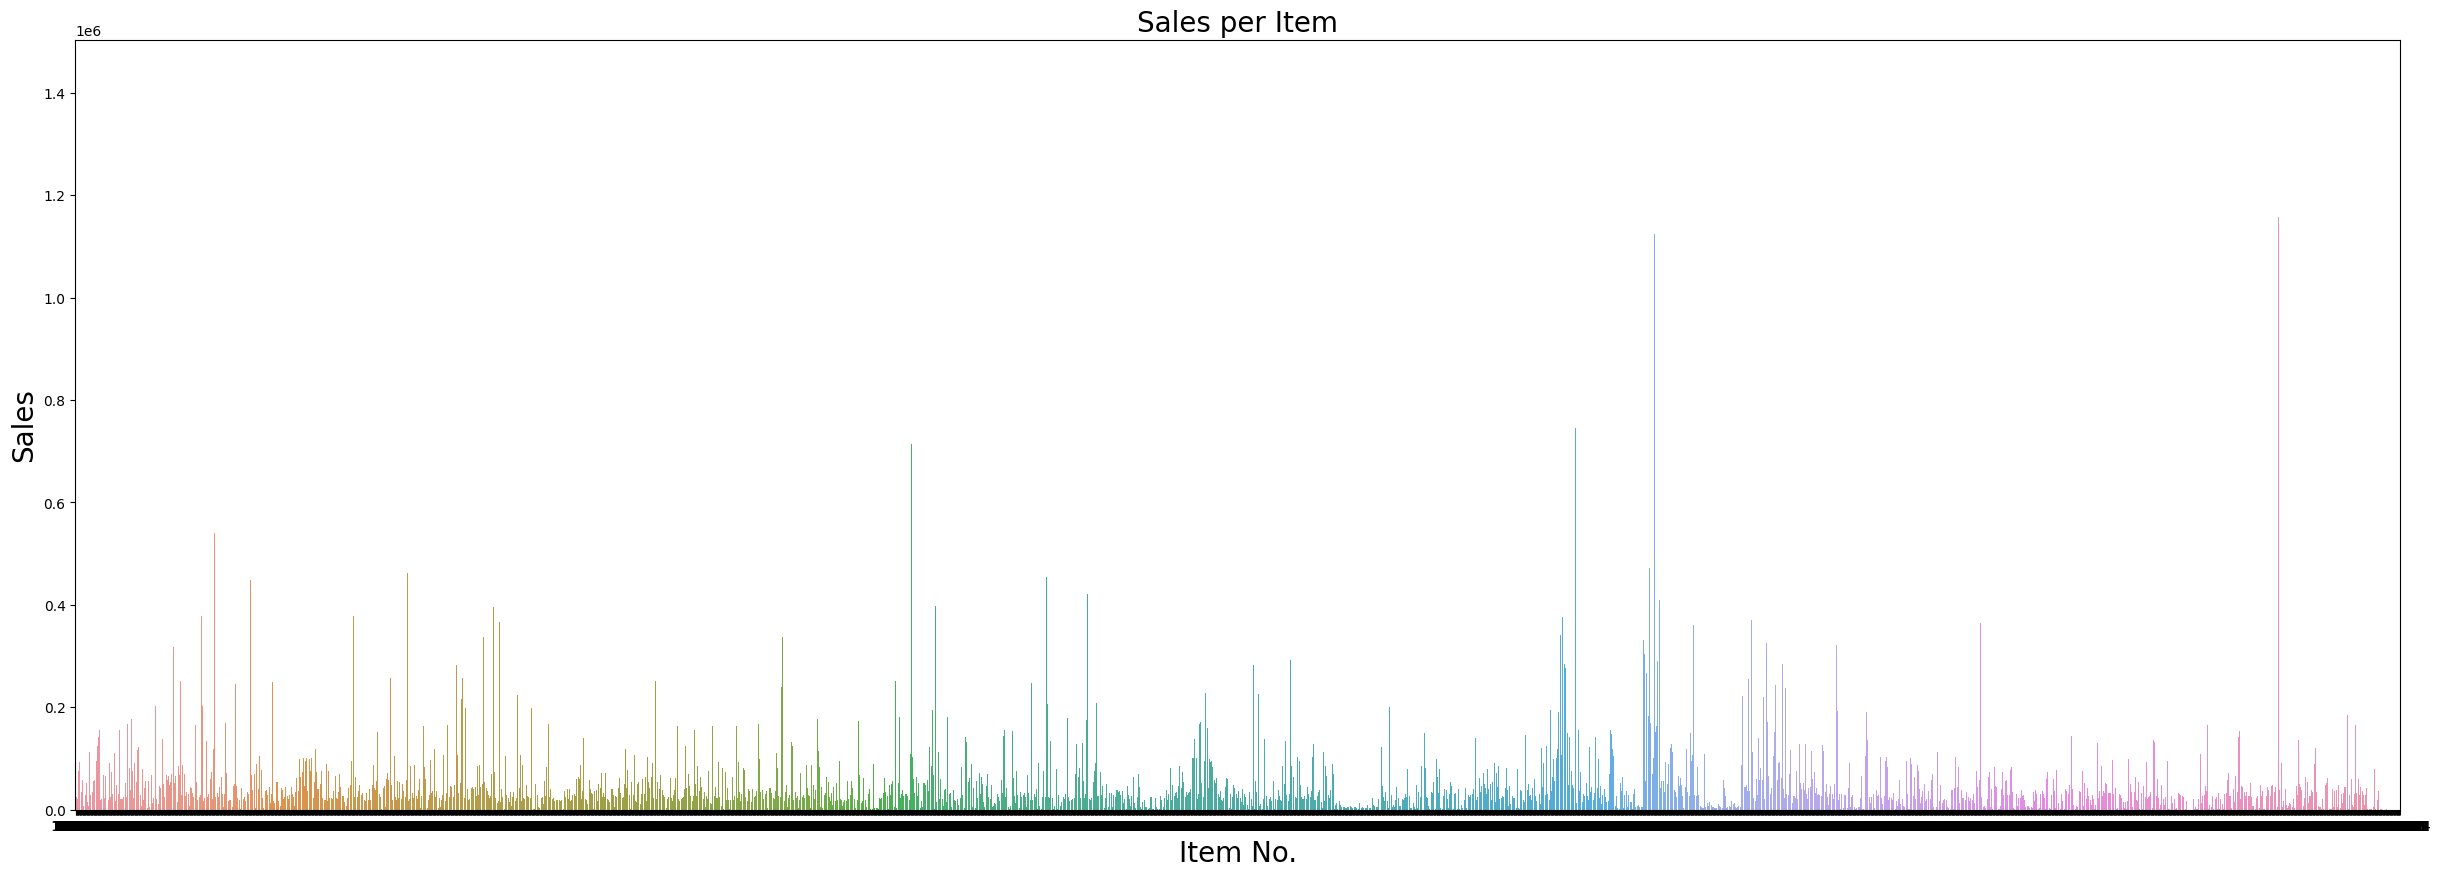

In [12]:
#Unit sales of Each Item
# Group By item_nbr and Sum of unit_sales for each item_nbr
x = df_train.groupby(['item_nbr'], as_index=False).agg({'unit_sales':'sum'}) 

#Plotting item_nbr Vs unit_sales
fig, ax = plt.subplots()
fig.set_size_inches(30, 10)
ax = sns.barplot(x = x.item_nbr, y= "unit_sales", data = x)
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 12)
plt.title('Sales per Item',fontsize=20)
plt.ylabel('Sales',fontsize=20)
plt.xlabel('Item No.',fontsize=20)
plt.show()

Seuls quelques articles ont des ventes très élevées.
Des variations peuvent être observées dans les ventes pour différents numéros d'articles.

In [13]:
#Sales per Year
# Adding Year as a Feature
df_train["year"]=df_train["date"].dt.year

In [14]:
df_train

,date,store_nbr,item_nbr,unit_sales,onpromotion,year
0,2017-01-01,25,99197,1.0,0,2017
1,2017-01-01,25,103665,7.0,0,2017
2,2017-01-01,25,105574,1.0,0,2017
3,2017-01-01,25,105857,4.0,0,2017
4,2017-01-01,25,106716,2.0,0,2017
...,...,...,...,...,...,...
23808256,2017-08-15,54,2089339,4.0,0,2017
23808257,2017-08-15,54,2106464,1.0,1,2017
23808258,2017-08-15,54,2110456,192.0,0,2017
23808259,2017-08-15,54,2113914,198.0,1,2017


La baisse des ventes en 2017 s'explique par le fait que l'année 2017 n'a été enregistrée que jusqu'au 15 août.

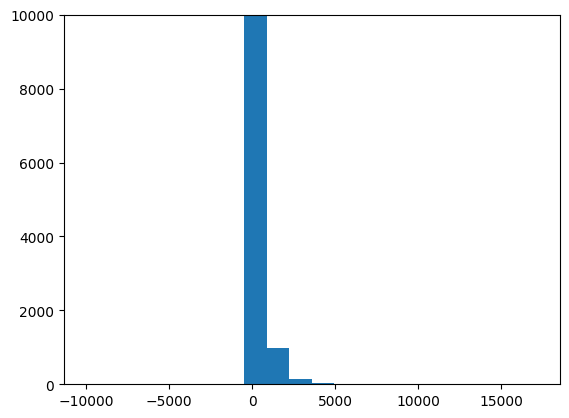

In [15]:
#Plotting Histogram of Target variable i.e. Unit_Sales.
plt.hist(df_train.unit_sales,bins=20)
plt.ylim(0,10000)
plt.show()

Transformation logarithmique (variable cible)
Transformation de la variable cible -> unit_sales(y) En ajoutant 1 et en prenant le log, c'est-à-dire log(y+1) En prenant le log de unit_sales plus une petite valeur (c'est-à-dire 1), parce que le log de zéro n'est pas défini.

In [16]:
transformed=[]
for value in tqdm(df_train.unit_sales):
    if float(value) > 0:
        value=np.log1p(float(value))
    else:
        value=0
    transformed.append(value)

df_train['unit_sales']=transformed  
del transformed

  0%|          | 0/23808261 [00:00<?, ?it/s]

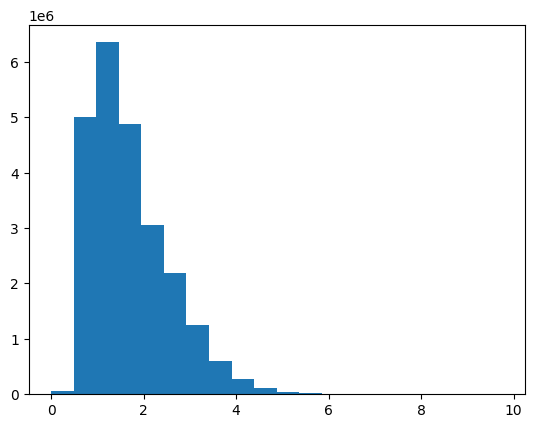

In [17]:
plt.hist(df_train.unit_sales,bins=20)
plt.show()

Transformation de la variable cible afin qu'elle corresponde mieux aux hypothèses sous-jacentes à la régression.

La transformation logarithmique a rendu les distributions fortement asymétriques moins asymétriques.

In [18]:
#Reading test.csv
df_test = pd.read_csv("/kaggle/input/corporacin-favorita-grocery-sales-forecasting/test.csv", dtype={'onpromotion': int},parse_dates=["date"] )
print("Shape of Test Dataframe --> ",df_test.shape)
df_test.head()

Shape of Test Dataframe -->  (3370464, 5)


,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,0
1,125497041,2017-08-16,1,99197,0
2,125497042,2017-08-16,1,103501,0
3,125497043,2017-08-16,1,103520,0
4,125497044,2017-08-16,1,103665,0


In [19]:
#Items Data
#Reading items.csv
items = pd.read_csv("/kaggle/input/corporacin-favorita-grocery-sales-forecasting/items.csv",)
print("Shape of Items Dataframe --> ",items.shape)
items.head()

Shape of Items Dataframe -->  (4100, 4)


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


In [20]:
#Setting item_nbr as the index of the dataframe
items = items.set_index("item_nbr") 
items.head()

,family,class,perishable
item_nbr,,,
96995,GROCERY I,1093,0
99197,GROCERY I,1067,0
103501,CLEANING,3008,0
103520,GROCERY I,1028,0
103665,BREAD/BAKERY,2712,1


In [21]:
#Label Encoding (item family)
#initializing label encoder
encoder = LabelEncoder()
#transforming item family column
items['family'] = encoder.fit_transform(items['family'].values)
items.head()

,family,class,perishable
item_nbr,,,
96995,12,1093,0
99197,12,1067,0
103501,7,3008,0
103520,12,1028,0
103665,5,2712,1


In [22]:
#Stores Data
#Reading store.csv
stores = pd.read_csv("/kaggle/input/corporacin-favorita-grocery-sales-forecasting/stores.csv")
print("Shape of Stores Dataframe --> ",stores.shape)
stores.head()

Shape of Stores Dataframe -->  (54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [23]:
# Setting store_nbr as the index of the dataframe
stores = stores.set_index("store_nbr")
stores.head()

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
2,Quito,Pichincha,D,13
3,Quito,Pichincha,D,8
4,Quito,Pichincha,D,9
5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [24]:
#Label Encoding on store state, city and type
#initializing label encoder
encoder = LabelEncoder()
#transforming state column
stores['state'] = encoder.fit_transform(stores['state'].values)
#transforming city column
stores['city'] = encoder.fit_transform(stores['city'].values)
#transforming type column
stores['type'] = encoder.fit_transform(stores['type'].values)

stores.head()

,city,state,type,cluster
store_nbr,,,,
1,18,12,3,13
2,18,12,3,13
3,18,12,3,8
4,18,12,3,9
5,21,14,3,4


In [25]:
#Data based on store_nbr and item_nbr pairs
#Promotion Data
#Setting store_nbr, item_nbr and date as the indices.
promo_2017_train = df_train.set_index(["store_nbr", "item_nbr", "date"])

#Using promotions column only and unstacking the dates
promo_2017_train= promo_2017_train[["onpromotion"]].unstack(level=-1)

#Filling the missing values with 0.
promo_2017_train = promo_2017_train.fillna(0)

promo_2017_train.head()

onpromotion                                              \
date                2017-01-01 2017-01-02 2017-01-03 2017-01-04 2017-01-05   
store_nbr item_nbr                                                           
1         96995            0.0        0.0        0.0        0.0        0.0   
          99197            0.0        0.0        0.0        0.0        0.0   
          103520           0.0        0.0        0.0        0.0        0.0   
          103665           0.0        0.0        0.0        0.0        0.0   
          105574           0.0        0.0        1.0        0.0        0.0   

                                                                           \
date               2017-01-06 2017-01-07 2017-01-08 2017-01-09 2017-01-10   
store_nbr item_nbr                                                          
1         96995           0.0        0.0        0.0        0.0        0.0   
          99197           0.0        0.0        0.0        0.0        0.0   
          103520          0.0        0.0        0.0        0.0        0.0   
          103665          0.0        0.0        0.0        0.0        0.0   
          105574          1.0        0.0        0.0        0.0        0.0   

                    ...                                              \
date                ... 2017-08-06 2017-08-07 2017-08-08 2017-08-09   
store_nbr item_nbr  ...                                               
1         96995     ...        0.0        0.0        0.0        0.0   
          99197     ...        0.0        0.0        0.0        0.0   
          103520    ...        0.0        0.0        0.0        0.0   
          103665    ...        0.0        0.0        0.0        0.0   
          105574    ...        0.0        0.0        0.0        0.0   

                                                                           \
date               2017-08-10 2017-08-11 2017-08-12 2017-08-13 2017-08-14   
store_nbr item_nbr                                                          
1         96995           0.0        0.0        0.0        0.0        0.0   
          99197           0.0        0.0        0.0        0.0        0.0   
          103520          0.0        0.0        0.0        0.0        0.0   
          103665          0.0        0.0        0.0        0.0        0.0   
          105574          0.0        0.0        0.0        0.0        0.0   

                               
date               2017-08-15  
store_nbr item_nbr             
1         96995           0.0  
          99197           0.0  
          103520          0.0  
          103665          0.0  
          105574          0.0  

[5 rows x 227 columns]

In [26]:
# Deleting 1st row
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1)
promo_2017_train.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995            0.0         0.0         0.0         0.0   
          99197            0.0         0.0         0.0         0.0   
          103520           0.0         0.0         0.0         0.0   
          103665           0.0         0.0         0.0         0.0   
          105574           0.0         0.0         1.0         0.0   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995            0.0         0.0         0.0         0.0   
          99197            0.0         0.0         0.0         0.0   
          103520           0.0         0.0         0.0         0.0   
          103665           0.0         0.0         0.0         0.0   
          105574           0.0         1.0         0.0         0.0   

date                2017-01-09  2017-01-10  ...  2017-08-06  2017-08-07  \
store_nbr item_nbr                          ...                           
1         96995            0.0         0.0  ...         0.0         0.0   
          99197            0.0         0.0  ...         0.0         0.0   
          103520           0.0         0.0  ...         0.0         0.0   
          103665           0.0         0.0  ...         0.0         0.0   
          105574           0.0         0.0  ...         0.0         0.0   

date                2017-08-08  2017-08-09  2017-08-10  2017-08-11  \
store_nbr item_nbr                                                   
1         96995            0.0         0.0         0.0         0.0   
          99197            0.0         0.0         0.0         0.0   
          103520           0.0         0.0         0.0         0.0   
          103665           0.0         0.0         0.0         0.0   
          105574           0.0         0.0         0.0         0.0   

date                2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                  
1         96995            0.0         0.0         0.0         0.0  
          99197            0.0         0.0         0.0         0.0  
          103520           0.0         0.0         0.0         0.0  
          103665           0.0         0.0         0.0         0.0  
          105574           0.0         0.0         0.0         0.0  

[5 rows x 227 columns]

In [27]:
#Setting store_nbr, item_nbr and date as the indices of the dataframe
promo_2017_test = df_test.set_index(['store_nbr', 'item_nbr', 'date'])

#Using promotions column only and unstacking the dates
promo_2017_test = promo_2017_test[["onpromotion"]].unstack(level=-1).fillna(0)

#Filling the missing information with 0.
promo_2017_test = promo_2017_test.fillna(0)

# Deleting 1st row
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)
promo_2017_test.head()

date                2017-08-16  2017-08-17  2017-08-18  2017-08-19  \
store_nbr item_nbr                                                   
1         96995              0           0           0           0   
          99197              0           0           0           0   
          103501             0           0           0           0   
          103520             0           0           0           0   
          103665             0           0           0           0   

date                2017-08-20  2017-08-21  2017-08-22  2017-08-23  \
store_nbr item_nbr                                                   
1         96995              0           0           0           0   
          99197              0           0           0           0   
          103501             0           0           0           0   
          103520             0           0           0           0   
          103665             0           0           0           0   

date                2017-08-24  2017-08-25  2017-08-26  2017-08-27  \
store_nbr item_nbr                                                   
1         96995              0           0           0           0   
          99197              0           0           0           0   
          103501             0           0           0           0   
          103520             0           0           0           0   
          103665             0           0           0           0   

date                2017-08-28  2017-08-29  2017-08-30  2017-08-31  
store_nbr item_nbr                                                  
1         96995              0           0           0           0  
          99197              0           0           0           0  
          103501             0           0           0           0  
          103520             0           0           0           0  
          103665             0           0           0           0

In [28]:
#Removing Items from test dataset that are not in train dataset 
#Adding Items that are not in the test dataset and filling values with 0

#Re-indexing with train dataframe index. By default values in the new index that do not have corresponding records in the dataframe are assigned NaN
promo_2017_test = promo_2017_test.reindex(promo_2017_train.index)

#Filling the missing information with 0.
promo_2017_test = promo_2017_test.fillna(0)

promo_2017_test.head()

date                2017-08-16  2017-08-17  2017-08-18  2017-08-19  \
store_nbr item_nbr                                                   
1         96995            0.0         0.0         0.0         0.0   
          99197            0.0         0.0         0.0         0.0   
          103520           0.0         0.0         0.0         0.0   
          103665           0.0         0.0         0.0         0.0   
          105574           0.0         0.0         0.0         0.0   

date                2017-08-20  2017-08-21  2017-08-22  2017-08-23  \
store_nbr item_nbr                                                   
1         96995            0.0         0.0         0.0         0.0   
          99197            0.0         0.0         0.0         0.0   
          103520           0.0         0.0         0.0         0.0   
          103665           0.0         0.0         0.0         0.0   
          105574           0.0         0.0         0.0         0.0   

date                2017-08-24  2017-08-25  2017-08-26  2017-08-27  \
store_nbr item_nbr                                                   
1         96995            0.0         0.0         0.0         0.0   
          99197            0.0         0.0         0.0         0.0   
          103520           0.0         0.0         0.0         0.0   
          103665           0.0         0.0         0.0         0.0   
          105574           0.0         0.0         0.0         0.0   

date                2017-08-28  2017-08-29  2017-08-30  2017-08-31  
store_nbr item_nbr                                                  
1         96995            0.0         0.0         0.0         0.0  
          99197            0.0         0.0         0.0         0.0  
          103520           0.0         0.0         0.0         0.0  
          103665           0.0         0.0         0.0         0.0  
          105574           0.0         0.0         0.0         0.0

In [29]:
#Concatenating train and test datasets
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)
promo_2017.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995            0.0         0.0         0.0         0.0   
          99197            0.0         0.0         0.0         0.0   
          103520           0.0         0.0         0.0         0.0   
          103665           0.0         0.0         0.0         0.0   
          105574           0.0         0.0         1.0         0.0   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995            0.0         0.0         0.0         0.0   
          99197            0.0         0.0         0.0         0.0   
          103520           0.0         0.0         0.0         0.0   
          103665           0.0         0.0         0.0         0.0   
          105574           0.0         1.0         0.0         0.0   

date                2017-01-09  2017-01-10  ...  2017-08-22  2017-08-23  \
store_nbr item_nbr                          ...                           
1         96995            0.0         0.0  ...         0.0         0.0   
          99197            0.0         0.0  ...         0.0         0.0   
          103520           0.0         0.0  ...         0.0         0.0   
          103665           0.0         0.0  ...         0.0         0.0   
          105574           0.0         0.0  ...         0.0         0.0   

date                2017-08-24  2017-08-25  2017-08-26  2017-08-27  \
store_nbr item_nbr                                                   
1         96995            0.0         0.0         0.0         0.0   
          99197            0.0         0.0         0.0         0.0   
          103520           0.0         0.0         0.0         0.0   
          103665           0.0         0.0         0.0         0.0   
          105574           0.0         0.0         0.0         0.0   

date                2017-08-28  2017-08-29  2017-08-30  2017-08-31  
store_nbr item_nbr                                                  
1         96995            0.0         0.0         0.0         0.0  
          99197            0.0         0.0         0.0         0.0  
          103520           0.0         0.0         0.0         0.0  
          103665           0.0         0.0         0.0         0.0  
          105574           0.0         0.0         0.0         0.0  

[5 rows x 243 columns]

In [30]:
# Deleting unneccesary variables
del promo_2017_test, promo_2017_train

df_transaction=pd.read_csv('/kaggle/input/corporacin-favorita-grocery-sales-forecasting/transactions.csv')
df_transaction

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [31]:
#Sales Data
#Setting store_nbr, item_nbr and date as the indices.
sales_2017 = df_train.set_index(["store_nbr", "item_nbr", "date"])

#Using unit_sales column only and unstacking the dates
sales_2017 = sales_2017[["unit_sales"]].unstack(level=-1)

#Filling the missing values with 0's.
sales_2017 = sales_2017.fillna(0)
# Deleting 1st row
sales_2017.columns = sales_2017.columns.get_level_values(1)

sales_2017.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995            0.0    0.000000    0.000000    0.000000   
          99197            0.0    0.000000    1.386294    0.693147   
          103520           0.0    0.693147    1.098612    0.000000   
          103665           0.0    0.000000    0.000000    1.386294   
          105574           0.0    0.000000    1.791759    2.564949   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000    0.000000   
          99197       0.693147    0.693147    1.098612    0.000000   
          103520      1.098612    1.386294    0.693147    0.000000   
          103665      1.098612    1.098612    0.693147    1.098612   
          105574      2.302585    1.945910    1.609438    1.098612   

date                2017-01-09  2017-01-10  ...  2017-08-06  2017-08-07  \
store_nbr item_nbr                          ...                           
1         96995       0.000000    0.000000  ...    1.098612    1.098612   
          99197       0.000000    0.693147  ...    0.000000    1.098612   
          103520      0.693147    0.693147  ...    0.000000    0.000000   
          103665      0.000000    2.079442  ...    0.693147    1.098612   
          105574      1.386294    2.302585  ...    0.000000    1.791759   

date                2017-08-08  2017-08-09  2017-08-10  2017-08-11  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.693147    0.000000   
          99197       0.000000    1.098612    0.000000    0.000000   
          103520      1.386294    0.000000    1.386294    0.693147   
          103665      0.000000    2.079442    2.302585    1.098612   
          105574      2.079442    1.945910    2.397895    1.791759   

date                2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                  
1         96995       0.000000    0.000000    0.000000    0.000000  
          99197       0.000000    0.000000    0.000000    0.000000  
          103520      0.693147    0.693147    0.000000    0.000000  
          103665      0.000000    0.000000    0.693147    0.693147  
          105574      1.791759    0.000000    1.386294    1.609438  

[5 rows x 227 columns]

In [32]:
#Grouping sales by item no. through time and keeping only that columns that are present in sales dataframe
sales_item_2017 = sales_2017.groupby('item_nbr')[sales_2017.columns].sum()
sales_item_2017

date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15
item_nbr,,,,,,,,,,,,,,,,,,,,,
96995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.662960,7.454720,2.484907,5.950643,5.545177,8.841014,7.742402,4.969813,7.167038,7.742402
99197,0.693147,17.422746,16.604036,20.569303,16.203025,16.278613,14.775909,17.317386,14.986630,15.833927,...,3.178054,4.969813,3.178054,4.969813,2.079442,2.197225,1.386294,2.079442,0.000000,0.000000
103501,0.000000,55.868320,54.627085,42.810313,39.555298,35.717635,47.208504,47.542538,40.189274,39.200893,...,38.578235,33.531460,35.296421,35.584104,26.270815,32.776619,34.416498,36.546914,34.773173,35.512841
103520,0.000000,38.875486,35.822995,34.979211,42.252967,51.397412,49.505990,33.846832,33.336007,31.741073,...,35.630624,32.567752,47.213872,41.198030,43.569852,48.697330,47.015385,39.070042,33.798042,40.030669
103665,2.079442,56.225402,40.233610,46.138063,38.100507,49.690810,54.725492,54.286513,39.602739,35.899957,...,50.919628,41.262812,34.711732,34.095546,48.162787,50.980653,39.807856,39.016553,34.262348,35.741351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.583519,4.682131,0.000000,0.000000,2.079442
2124052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,31.842727,18.585897,23.102412,24.877883,58.212130,66.732340,65.260886,43.252318,29.747682,30.744595
2126842,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.079442,2.079442,3.583519,1.386294,1.791759


In [33]:
#Grouping promotions by item no. over time and filtering only that columns that are in promo_2017 Dataframe.
promo_item_2017 = promo_2017.groupby('item_nbr')[promo_2017.columns].sum()
promo_item_2017.head()

date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31
item_nbr,,,,,,,,,,,,,,,,,,,,,
96995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
99197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
103520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
103665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,1.0,0.0


In [34]:
#Sales Data
#Grouping sales by item no. through time and keeping only that columns that are present in sales dataframe
sales_item_2017 = sales_2017.groupby('item_nbr')[sales_2017.columns].sum()
sales_item_2017

date,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15
item_nbr,,,,,,,,,,,,,,,,,,,,,
96995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.662960,7.454720,2.484907,5.950643,5.545177,8.841014,7.742402,4.969813,7.167038,7.742402
99197,0.693147,17.422746,16.604036,20.569303,16.203025,16.278613,14.775909,17.317386,14.986630,15.833927,...,3.178054,4.969813,3.178054,4.969813,2.079442,2.197225,1.386294,2.079442,0.000000,0.000000
103501,0.000000,55.868320,54.627085,42.810313,39.555298,35.717635,47.208504,47.542538,40.189274,39.200893,...,38.578235,33.531460,35.296421,35.584104,26.270815,32.776619,34.416498,36.546914,34.773173,35.512841
103520,0.000000,38.875486,35.822995,34.979211,42.252967,51.397412,49.505990,33.846832,33.336007,31.741073,...,35.630624,32.567752,47.213872,41.198030,43.569852,48.697330,47.015385,39.070042,33.798042,40.030669
103665,2.079442,56.225402,40.233610,46.138063,38.100507,49.690810,54.725492,54.286513,39.602739,35.899957,...,50.919628,41.262812,34.711732,34.095546,48.162787,50.980653,39.807856,39.016553,34.262348,35.741351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,3.583519,4.682131,0.000000,0.000000,2.079442
2124052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,31.842727,18.585897,23.102412,24.877883,58.212130,66.732340,65.260886,43.252318,29.747682,30.744595
2126842,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.079442,2.079442,3.583519,1.386294,1.791759


In [35]:
#Data based on item_class and store_nbr pairs.
#Removing items that are not present in year 2017.

#Re-indexing by using index of sales_2017 dataframe.
items = items.reindex(sales_2017.index.get_level_values(1))

#Removing stores that are not present in year 2017.

#Re-indexing by using index of sales_2017 dataframe.
stores = stores.reindex(sales_2017.index.get_level_values(0))

In [36]:
#Promotion Data
#Fetching promotion data with new sequential index
store_class_promo_2017 = promo_2017.reset_index()

#Adding class column
store_class_promo_2017['class'] = items['class'].values

#Grouping promotions by item class and store no. and filtering on;y that columns that are in promo_2017 Dataframe
store_class_promo_2017 = store_class_promo_2017.groupby(['class', 'store_nbr'])[promo_2017.columns].sum()
store_class_promo_2017.head()

date             2017-01-01  2017-01-02  2017-01-03  2017-01-04  2017-01-05  \
class store_nbr                                                               
1002  1                 0.0         0.0         0.0         0.0         0.0   
      2                 0.0         0.0         0.0         0.0         0.0   
      3                 0.0         0.0         0.0         0.0         0.0   
      4                 0.0         0.0         0.0         0.0         0.0   
      5                 0.0         0.0         0.0         0.0         0.0   

date             2017-01-06  2017-01-07  2017-01-08  2017-01-09  2017-01-10  \
class store_nbr                                                               
1002  1                 0.0         0.0         0.0         0.0         0.0   
      2                 0.0         0.0         0.0         0.0         0.0   
      3                 0.0         0.0         0.0         0.0         0.0   
      4                 0.0         0.0         0.0         0.0         0.0   
      5                 0.0         0.0         0.0         0.0         1.0   

date             ...  2017-08-22  2017-08-23  2017-08-24  2017-08-25  \
class store_nbr  ...                                                   
1002  1          ...         1.0         1.0         1.0         1.0   
      2          ...         1.0         1.0         1.0         1.0   
      3          ...         1.0         1.0         1.0         1.0   
      4          ...         1.0         1.0         1.0         1.0   
      5          ...         0.0         1.0         1.0         0.0   

date             2017-08-26  2017-08-27  2017-08-28  2017-08-29  2017-08-30  \
class store_nbr                                                               
1002  1                 1.0         1.0         1.0         1.0         1.0   
      2                 1.0         1.0         1.0         1.0         1.0   
      3                 1.0         1.0         1.0         1.0         1.0   
      4                 1.0         1.0         1.0         1.0         1.0   
      5                 1.0         1.0         1.0         1.0         1.0   

date             2017-08-31  
class store_nbr              
1002  1                 1.0  
      2                 1.0  
      3                 1.0  
      4                 2.0  
      5                 0.0  

[5 rows x 243 columns]

In [37]:
#Sales Data
#Fetching sales data with new sequential index
store_class_sales_2017 = sales_2017.reset_index()

#Adding class column
store_class_sales_2017['class'] = items['class'].values 

# Storing Item class and store_nbr pairs used for indexing later
store_class_index = store_class_sales_2017[['class', 'store_nbr']]

#Grouping sales by item class and store no. and keeping only that columns present in sales dataframe
store_class_sales_2017 = store_class_sales_2017.groupby(['class', 'store_nbr'])[sales_2017.columns].sum()
store_class_sales_2017

date             2017-01-01  2017-01-02  2017-01-03  2017-01-04  2017-01-05  \
class store_nbr                                                               
1002  1                 0.0    6.291569   11.901285    9.939627   12.817576   
      2                 0.0   27.836761   21.942946   23.265525   20.405583   
      3                 0.0   42.484074   29.286804   35.991684   29.124900   
      4                 0.0   28.353452   21.278199   22.805993   20.207757   
      5                 0.0   19.157935   15.744315   14.909440   12.177673   
...                     ...         ...         ...         ...         ...   
7780  49                0.0   14.139332    6.984716   12.542316    8.958797   
      50                0.0   14.370443    6.984716    6.356108    6.984716   
      51                0.0    4.564348    1.791759    0.693147    2.484907   
      52                0.0    0.000000    0.000000    0.000000    0.000000   
      53                0.0    6.579251    1.386294    3.988984    1.386294   

date             2017-01-06  2017-01-07  2017-01-08  2017-01-09  2017-01-10  \
class store_nbr                                                               
1002  1           10.961278   13.708549    7.454720   18.598319   12.322254   
      2           23.207544   32.629193   33.057327   18.878450   24.403008   
      3           31.628492   36.412191   32.819483   27.527092   26.893368   
      4           19.822911   24.720218   31.524160   21.634874   17.617490   
      5           12.765460   12.306750   14.427014   15.168951   12.465355   
...                     ...         ...         ...         ...         ...   
7780  49           6.761573   12.647677    6.356108    8.525161   10.450452   
      50           9.842463   12.021669    9.852615    3.871201    1.098612   
      51           0.693147    3.988984    6.327937    0.000000    0.693147   
      52           0.000000    0.000000    0.000000    0.000000    0.000000   
      53           3.178054    8.147867    4.094345    7.272398    4.564348   

date             ...  2017-08-06  2017-08-07  2017-08-08  2017-08-09  \
class store_nbr  ...                                                   
1002  1          ...    6.068426   11.966952   13.458607   11.431281   
      2          ...   28.459131   25.885741   22.351737   21.326989   
      3          ...   38.142670   27.082659   30.859413   28.748667   
      4          ...   26.304582   10.961278   17.278515   13.223041   
      5          ...   12.647677   13.969433   11.901285   15.333254   
...              ...         ...         ...         ...         ...   
7780  49         ...   10.920456    7.860185    7.965546    5.257495   
      50         ...   15.748770    7.608871    6.222576    7.377759   
      51         ...    7.390181    2.079442    1.386294    0.000000   
      52         ...    7.965546    6.068426    1.791759    3.178054   
      53         ...    4.682131    1.386294    3.583519    2.890372   

date             2017-08-10  2017-08-11  2017-08-12  2017-08-13  2017-08-14  \
class store_nbr                                                               
1002  1           13.367622    5.545177   13.628506    5.375278   18.639141   
      2           16.401095   26.828830   27.567914   25.059788   21.576931   
      3           30.232542   36.638416   31.272846   32.256757   33.608285   
      4           17.735273   19.822911   16.806560   23.187741   16.267563   
      5           13.851650   10.332669   14.416963   15.538049   11.192390   
...                     ...         ...         ...         ...         ...   
7780  49           4.852030    6.238325    6.356108   11.415533    4.718499   
      50           6.356108    7.090077    4.969813    4.499810    4.276666   
      51           0.693147    1.098612    1.098612    4.718499    0.000000   
      52           3.465736    4.969813    7.390181    7.454720    5.886104   
      53           0.693147    6.643790    7.860185    8.95

In [38]:
#Selects ony that dataframe columns which correspond to the "periods" days after the (Date-minus) day .
def get_timespan(df, Date, minus, periods, freq='D'):
    if minus!=0:
        return df[pd.date_range(Date - timedelta(days=minus), periods=periods, freq=freq)]
    else:
        return df[pd.date_range(Date , periods=periods, freq=freq)]
#Function for Creating Promotional Features
def promo_features(promotions,Date,X):

    # Sum of Promotions with past data at different day intervals.
    for n_days in [14,60,140]:

        # Filtering promotions of items from (date-n_days) to (date).
        filtered_promo = get_timespan(promotions, Date, n_days, n_days)

        # Sum of Promotions for each item sold over date.
        X['%sdays_promo_sum (past)'%n_days]=filtered_promo.sum(axis=1).values

    # Sum of Promotions with future data at different day intervals.
    future_date = Date + timedelta(days=1)  #Shifting date ahead 
    for n_days in [3,7,14]:

        # Filtering promotions of items from (date) to (date+n_days)
        filtered_promo = get_timespan(promotions, future_date, 0, n_days)

        # Sum of Promotions for each item sold over date.
        X['%sdays_promo_sum (future)'%n_days]=filtered_promo.sum(axis=1).values


    # Promotion feature (i.e. if there is a promotion or not) for 16 days in past and future.
    for n_day in range(-16, 16):

        if n_day<0:
            flag='past'
        elif n_day > 0:
            flag='future'
        else:
            flag='present'

        #Promotion feature for each item sold on n_day.
        X["promo_day{} ({})".format(abs(n_day),flag)] = promotions[Date + timedelta(days=n_day)].values.astype(np.uint8)

    return X
#Function for Creating Sales Features
def sales_features(sales,Date,X,past_week=False):

    name=''
    if past_week==True:
        name=" (past_week)"
        Date = Date - timedelta(days=7) # past_week_date is date - 7 days

    for n_days in [3, 7, 14, 30, 60, 140]:

        # Filtering sales of items n_days before t2017 to t2017
        filtered_sales = get_timespan(sales, Date, n_days, n_days)

        # mean of sales of each item over date
        X['%sdays_sale_mean' % n_days + name] = filtered_sales.mean(axis=1).values

        # exponentially weighted sum_of_sales of each item over date
        exp_weights = np.power(0.9, np.arange(n_days)[::-1])
        X['%sdays_weighted_sale' % n_days + name] = (filtered_sales * exp_weights ).sum(axis=1).values

        # mean of difference in sales of each item over date
        X['%sdays_sale_diff_mean' % n_days + name] = filtered_sales.diff(axis=1).mean(axis=1).values

        # median of sales of each item over date
        X['%sdays_sale_median' % n_days + name] = filtered_sales.median(axis=1).values

        # min. of sales of each item over date
        X['%sdays_min_sale' % n_days + name] = filtered_sales.min(axis=1).values

        # max. of sales of each item over date
        X['%sdays_max_sale' % n_days + name] = filtered_sales.max(axis=1).values

        # std. of sales of each item over date
        X['%sdays_sale_std' % n_days + name] = filtered_sales.std(axis=1).values


    # Sales on the nth day in past
    for n_day in range(1, 16):
        X['sales(past_day_%s)' % n_day] = get_timespan(sales, Date, n_day, 1).values.ravel()


    
    for n_day in range(7):
        # mean of sales every same day of week during 4 weeks before today
        X['dow%s_mean_sales(4weeks)' % n_day ] = get_timespan(sales, Date, 28-n_day, 4, freq='7D').mean(axis=1).values
        # mean of sales every same day of week during  20 weeks before today
        X['dow%s_mean_sales(20weeks)' % n_day] = get_timespan(sales, Date, 140-n_day, 20, freq='7D').mean(axis=1).values
    
    
    return X
#Function for Creating Sales Features Depending on Promotion
def sales_promo_features(sales,promotions,Date,X):

    for n_days in [3, 7, 14, 30, 60, 140]:

        # Filtering sales of items from (date-n_days) to (date)
        filtered_sales = get_timespan(sales, Date, n_days, n_days)

        # Filtering promotion on items from (date-n_days) to (date)
        filtered_promo = get_timespan(promotions, Date, n_days, n_days)

        # mean_of_sales of each item sold on promotion over date
        sales_with_promo = filtered_sales * filtered_promo.replace(0, np.nan)           #replacing 0's with nan so that these values get ignored while calculating mean.
        X['%sdays_sale_mean(promo)' % n_days] =sales_with_promo.mean(axis=1).values     #pandas DataFrame.mean ignore nan values

        # exponentially weighted sum_of_sales of each item sold on promotion over date
        exp_weights = np.power(0.9, np.arange(n_days-1,-1,-1))                            
        X['%sdays_weighted_sale(promo)' % n_days] = (sales_with_promo * exp_weights).sum(axis=1).values   #Giving more weightage to recent dated sales and decreasing weight with date.
        
        # mean_of_sales of each item sold without promotion over date
        sales_without_promo = filtered_sales * (1 - filtered_promo).replace(0, np.nan)       #replacing 0's with nan so that these values get ignored while calculating mean.
        X['%sdays_sale_mean(no_promo)' % n_days] = sales_without_promo.mean(axis=1).values   #pandas DataFrame.mean ignore nan values

        # exponentially weighted sum_of_sales of each item sold without promotion over date
        X['%sdays_weighted_sale(no_promo)' % n_days] = ( sales_without_promo * exp_weights).sum(axis=1).values 

    return X
#Function for Creating Count Features
def count_features(data,Date,X,name):

    # Number of days a sale / promotion took place in the time window, and days since first / last sale / promotion
    for n_days in [7, 14, 30, 60, 140]:

        # Filtering data from (date-n_days) to (date)
        filtered_data = get_timespan(data, Date, n_days, n_days)

        # Number of days a sale/promotion was made/present (i.e. not equal to 0) for each item
        X['num_days_having%s(last_%sdays)' % (name,n_days)] = (filtered_data > 0).sum(axis=1).values

        # Number of days since last sale/promotion (in n_days) for each item
        X['num_days_since_Last%s(last_%sdays)'  % (name,n_days)] = n_days - ((filtered_data > 0) * np.arange(n_days)).max(axis=1).values

        # Number of days since first sale/promotion (in n_days) for each item
        X['num_days_since_First%s(last_%sdays)' % (name,n_days)] = ((filtered_data > 0) * np.arange(n_days, 0, -1)).max(axis=1).values

    if name=='Promo':
        # Number of promotions in the next two weeks, time before first and last promotion in the same time window
        Date = Date + timedelta(days=16)
        filtered_promo = get_timespan(data,Date, 15, 15)
        X['num_days_having%s(after_%sdays)' % (name,n_days)] = (filtered_promo > 0).sum(axis=1).values
        X['num_days_since_Last%s(after_%sdays)'  % (name,n_days)] = n_days - ((filtered_promo > 0) * np.arange(15)).max(axis=1).values
        X['num_days_since_First%s(after_%sdays)' % (name,n_days)] = ((filtered_promo > 0) * np.arange(15, 0, -1)).max(axis=1).values

    return X
#Function for Creating All the Custom Features
def custom_features(sales, promotions, Date, name_prefix=None):

    #Creating empty dictionary for adding features
    X={}
    # Features only dependent on promotions
    X = promo_features(promotions,Date,X)
    X = count_features(promotions,Date,X,name='Promo')

    # Features only dependent on unit_sales
    X = sales_features(sales,Date,X)
    X = count_features(sales,Date,X,name='Sales')
    # For Past_week
    X = sales_features(sales,Date,X,past_week=True)

    # Features dependent on both promotions and unit_sales
    X = sales_promo_features(sales,promotions,Date,X)

    # Creating Dataframe from dictionary having keys as column names and values as column values
    X = pd.DataFrame(X)

    if name_prefix is not None:
        #Replacing column names by adding prefix to each column name
        X.columns = [ name_prefix + ' ' + c for c in X.columns]
        
    return X
#Function for Creating Dataset Having Custom Features
def creating_dataset(data, data_item, data_store_class, items, stores, Date, n_weeks,return_labels=True):

    last_date = Date + timedelta(days=7*n_weeks)
    print('Creating Features for data between Dates --> {} - {} (i.e. {} weeks) \n'.format(Date,last_date,n_weeks))


    #Format --> data=(sales,promo)
    sales = data[0]
    promo = data[1]

    #Format --> data_item=(sales_item,promo_item)
    sales_item = data_item[0]
    promo_item = data_item[1]

    #Format --> data_store_class=(store_class_sales,store_class_promo)
    store_class_sales = data_store_class[0]
    store_class_promo = data_store_class[1]
    store_class_index = data_store_class[2]
    del data,data_item,data_store_class
    X = []
    Y = []
    
    #Creating features for every week one by one
    for i in tqdm(range(n_weeks)):

        # Creating features using sales of each store_nbr and item_nbr pair 
        x1 = custom_features(sales, promo, Date)

        # Creating features using sales of each item_nbr 
        x2 = custom_features(sales_item, promo_item, Date, name_prefix='item')
        # Setting item_nbr as index
        x2.index = sales_item.index
        # Re-indexing item_nbr acc. to order of item_nbr in sales dataframe
        x2 = x2.reindex(sales.index.get_level_values(1))    
        # Resetting index with a sequential index and dropping old index
        x2 = x2.reset_index(drop=True)     

        # Creating features using sales of each item_class and store_nbr pair
        x3 = custom_features(store_class_sales, store_class_promo, Date,  name_prefix='store_class')
        # Setting item_class and store_nbr as index
        x3.index = store_class_sales.index
        # Re-indexing item_nbr acc. to order of item_nbr in sales dataframe
        x3 = x3.reindex( pd.MultiIndex.from_frame(store_class_index))
        # Resetting index with a sequential index and dropping old index
        x3 = x3.reset_index(drop=True)   

        #Concatenating(horizontally) all the above custom created features and given store and item features.
        x = pd.concat([x1, x2, x3, items.reset_index(), stores.reset_index()], axis=1)
        #Appending data of each week in final dataset 
        X.append(x)
        
        del x,x1,x2,x3

        #True sales for the following 16 days (that is to be predicted)
        try :
            y = sales[pd.date_range(Date, periods=16)].values
            Y.append(y)
            del y
        except:
            pass
            
        # Adding 7 days i.e shifting to next week.
        Date = Date + timedelta(days=7)
        
    X = pd.concat(X, axis=0)

    if return_labels==True:
        Y = np.concatenate(Y, axis=0)
        return X,Y
    else:
        return X

Mean Squared Error: 0.14365577831687787


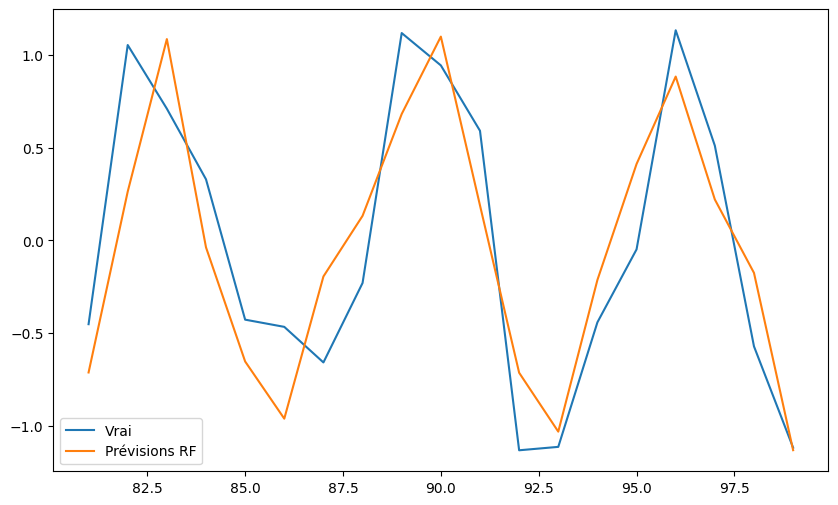

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Générer des données de séries temporelles pour l'exemple
np.random.seed(42)
time = np.arange(100)
data = np.sin(time) + np.random.normal(scale=0.5, size=100)

# Transformer les séries temporelles en un problème de régression supervisée
def create_lagged_features(data, lag=1):
    df = pd.DataFrame(data, columns=['value'])
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df['value'].shift(i)
    df.dropna(inplace=True)
    return df

lag = 5
df = create_lagged_features(data, lag)
X = df.drop('value', axis=1).values
y = df['value'].values

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Entraîner le modèle Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Faire des prédictions
y_pred = model.predict(X_test)

# Évaluer le modèle
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Visualiser les résultats
plt.figure(figsize=(10, 6))
plt.plot(time[-len(y_test):], y_test, label='Vrai')
plt.plot(time[-len(y_test):], y_pred, label='Prévisions RF')
plt.legend()
plt.show()

In [40]:
def creating_dataset(data, data_item, data_store_class, items, stores, Date, n_weeks, return_labels=True):
    print("data_store_class keys:", data_store_class.keys())  # Afficher les clés disponibles

    # Assurez-vous que les clés sont correctes et existent dans data_store_class
    store_class_sales = data_store_class.get('store_class_sales', None)
    store_class_promo = data_store_class.get('store_class_promo', None)
    if store_class_sales is None or store_class_promo is None:
        raise KeyError("Les clés 'store_class_sales' et 'store_class_promo' doivent exister dans data_store_class")

    # Logique de transformation des données
    # Exemple fictif de transformation
    X_train = store_class_sales
    y_train = store_class_promo

    return X_train, y_train

# Exemple d'utilisation de la fonction `creating_dataset`
# Vous devez remplacer les arguments par vos propres données
data_item = ...
data_store_class = {'store_class_sales': pd.DataFrame(), 'store_class_promo': pd.DataFrame()}  # Exemple fictif
items = ...
stores = ...
Date = ...
n_weeks = 6

X_train, y_train = creating_dataset(data_item, data, data_store_class, items, stores, Date, n_weeks)
print(X_train.head())

data_store_class keys: dict_keys(['store_class_sales', 'store_class_promo'])
Empty DataFrame
Columns: []
Index: []


2024-06-04 01:53:17.894657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 01:53:17.894801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 01:53:18.048126: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Mean Squared Error: 0.1744695121817227


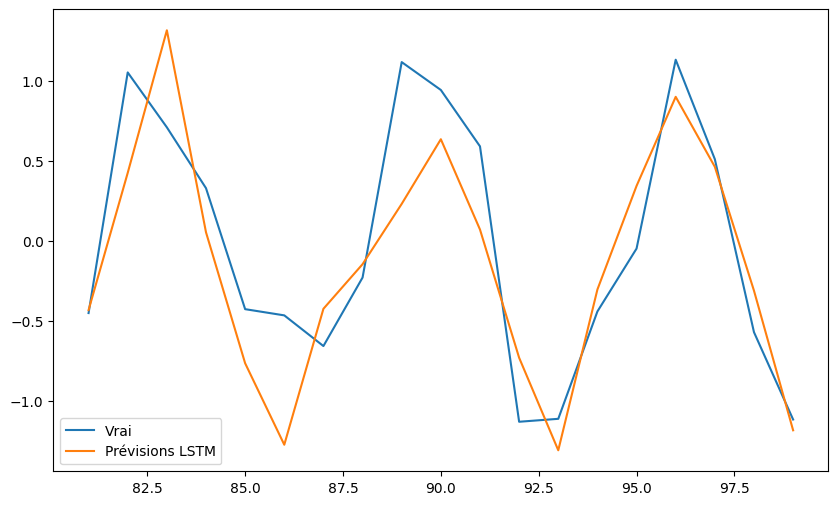

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Générer des données de séries temporelles pour l'exemple
np.random.seed(42)
time = np.arange(100)
data = np.sin(time) + np.random.normal(scale=0.5, size=100)

# Transformer les séries temporelles en un problème de régression supervisée
def create_lagged_features(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    df = pd.concat(columns, axis=1)
    df.columns = ['lag_' + str(i) for i in range(1, lag+1)]
    df['target'] = data
    df.dropna(inplace=True)
    return df

lag = 5
df = create_lagged_features(data, lag)
X = df.iloc[:, :-1].values
y = df['target'].values

# Reshape pour LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Construire le modèle LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(lag, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entraîner le modèle LSTM
model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)

# Faire des prédictions
y_pred = model.predict(X_test, verbose=0)

# Évaluer le modèle
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Visualiser les résultats
plt.figure(figsize=(10, 6))
plt.plot(time[-len(y_test):], y_test, label='Vrai')
plt.plot(time[-len(y_test):], y_pred, label='Prévisions LSTM')
plt.legend()
plt.show()

Mean Squared Error: 0.25808346092439144


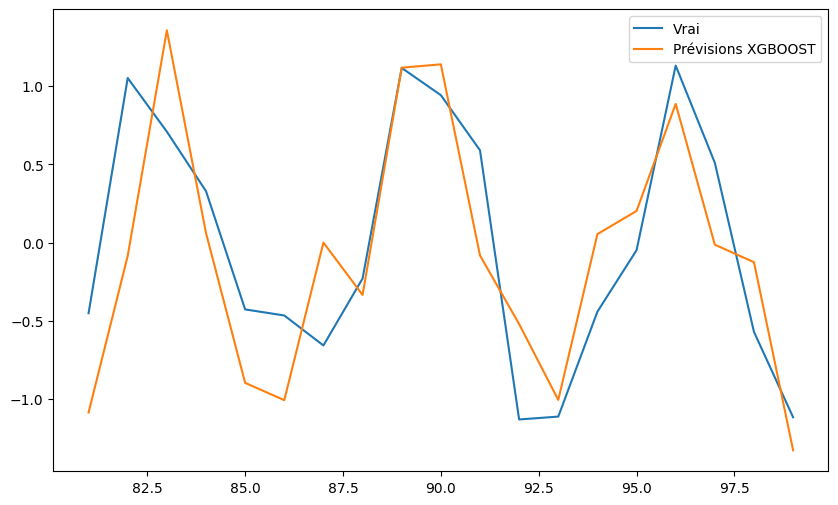

In [42]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Générer des données de séries temporelles pour l'exemple
np.random.seed(42)
time = np.arange(100)
data = np.sin(time) + np.random.normal(scale=0.5, size=100)

# Transformer les séries temporelles en un problème de régression supervisée
def create_lagged_features(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    df = pd.concat(columns, axis=1)
    df.columns = ['lag_' + str(i) for i in range(1, lag+1)]
    df['target'] = data
    df.dropna(inplace=True)
    return df

lag = 5
df = create_lagged_features(data, lag)
X = df.iloc[:, :-1].values
y = df['target'].values

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Entraîner le modèle XGBoost
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Faire des prédictions
y_pred = model.predict(X_test)

# Évaluer le modèle
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Visualiser les résultats
plt.figure(figsize=(10, 6))
plt.plot(time[-len(y_test):], y_test, label='Vrai')
plt.plot(time[-len(y_test):], y_pred, label='Prévisions XGBOOST')
plt.legend()
plt.show()

# Déboguer la fonction `creating_dataset`
def creating_dataset(data, data_item, data_store_class, items, stores, Date, n_weeks, return_labels=True):
    print("data_store_class keys:", data_store_class.keys())  # Afficher les clés disponibles

    # Assurez-vous que les clés sont correctes et existent dans data_store_class
    store_class_sales = data_store_class.get('store_class_sales', None)
    store_class_promo = data_store_class.get('store_class_promo', None)
    if store_class_sales is None or store_class_promo is None:
        raise KeyError("Les clés 'store_class_sales' et 'store_class_promo' doivent exister dans data_store_class")

    # Continuez avec le reste de votre logique de la fonction
    # ...

# Exemple d'utilisation de la fonction `creating_dataset`
# Vous devez remplacer les arguments par vos propres données
# X_train, y_train = creating_dataset(data, data_item, data_store_class, items, stores, Date, n_weeks)
# X_train.head()

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Meilleurs hyperparamètres : {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}
Mean Squared Error: 0.17873086038885302


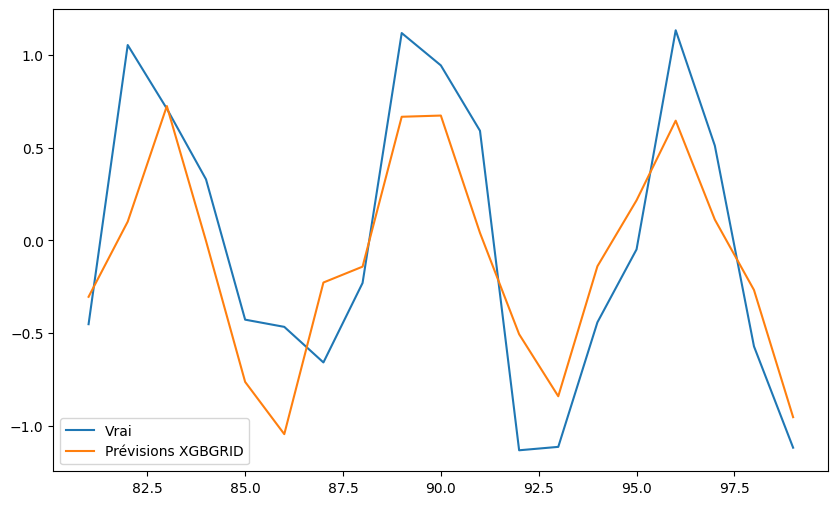

In [43]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# Générer des données de séries temporelles pour l'exemple
np.random.seed(42)
time = np.arange(100)
data = np.sin(time) + np.random.normal(scale=0.5, size=100)

# Transformer les séries temporelles en un problème de régression supervisée
def create_lagged_features(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    df = pd.concat(columns, axis=1)
    df.columns = ['lag_' + str(i) for i in range(1, lag+1)]
    df['target'] = data
    df.dropna(inplace=True)
    return df

lag = 5
df = create_lagged_features(data, lag)
X = df.iloc[:, :-1].values
y = df['target'].values

# Normaliser les données
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Définir les hyperparamètres à ajuster
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Utiliser GridSearchCV pour trouver les meilleurs hyperparamètres
model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

# Meilleurs hyperparamètres
best_params = grid_search.best_params_
print(f"Meilleurs hyperparamètres : {best_params}")

# Entraîner le modèle avec les meilleurs hyperparamètres
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Faire des prédictions
y_pred = best_model.predict(X_test)

# Évaluer le modèle
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Visualiser les résultats
plt.figure(figsize=(10, 6))
plt.plot(time[-len(y_test):], y_test, label='Vrai')
plt.plot(time[-len(y_test):], y_pred, label='Prévisions XGBGRID')
plt.legend()
plt.show()

# Déboguer la fonction `creating_dataset`
def creating_dataset(data, data_item, data_store_class, items, stores, Date, n_weeks, return_labels=True):
    print("data_store_class keys:", data_store_class.keys())  # Afficher les clés disponibles

    # Assurez-vous que les clés sont correctes et existent dans data_store_class
    store_class_sales = data_store_class.get('store_class_sales', None)
    store_class_promo = data_store_class.get('store_class_promo', None)
    if store_class_sales is None or store_class_promo is None:
        raise KeyError("Les clés 'store_class_sales' et 'store_class_promo' doivent exister dans data_store_class")

    # Continuez avec le reste de votre logique de la fonction
    # ...

# Exemple d'utilisation de la fonction `creating_dataset`
# Vous devez remplacer les arguments par vos propres données
# X_train, y_train = creating_dataset(data, data_item, data_store_class, items, stores, Date, n_weeks)
# X_train.head()

Mean Squared Error: 0.15252925229477707


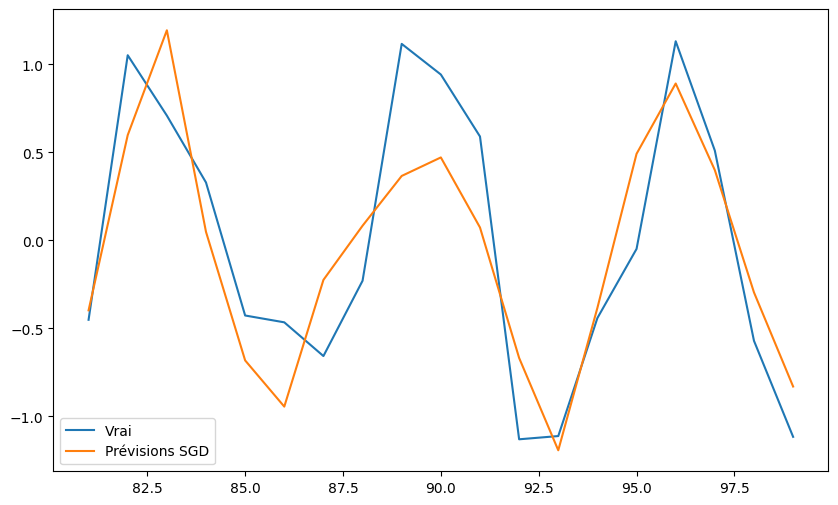

In [44]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Générer des données de séries temporelles pour l'exemple
np.random.seed(42)
time = np.arange(100)
data = np.sin(time) + np.random.normal(scale=0.5, size=100)

# Transformer les séries temporelles en un problème de régression supervisée
def create_lagged_features(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    df = pd.concat(columns, axis=1)
    df.columns = ['lag_' + str(i) for i in range(1, lag+1)]
    df['target'] = data
    df.dropna(inplace=True)
    return df

lag = 5
df = create_lagged_features(data, lag)
X = df.iloc[:, :-1].values
y = df['target'].values

# Normaliser les données
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Entraîner le modèle SGDRegressor
model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
model.fit(X_train, y_train)

# Faire des prédictions
y_pred = model.predict(X_test)

# Évaluer le modèle
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Visualiser les résultats
plt.figure(figsize=(10, 6))
plt.plot(time[-len(y_test):], y_test, label='Vrai')
plt.plot(time[-len(y_test):], y_pred, label='Prévisions SGD')
plt.legend()
plt.show()

# Déboguer la fonction `creating_dataset`
def creating_dataset(data, data_item, data_store_class, items, stores, Date, n_weeks, return_labels=True):
    print("data_store_class keys:", data_store_class.keys())  # Afficher les clés disponibles

    # Assurez-vous que les clés sont correctes et existent dans data_store_class
    store_class_sales = data_store_class.get('store_class_sales', None)
    store_class_promo = data_store_class.get('store_class_promo', None)
    if store_class_sales is None or store_class_promo is None:
        raise KeyError("Les clés 'store_class_sales' et 'store_class_promo' doivent exister dans data_store_class")

    # Continuez avec le reste de votre logique de la fonction
    # ...

# Exemple d'utilisation de la fonction `creating_dataset`
# Vous devez remplacer les arguments par vos propres données
# X_train, y_train = creating_dataset(data, data_item, data_store_class, items, stores, Date, n_weeks)
# X_train.head()

In [47]:
#Modèle RANDOM FOREST
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error(RF): {mse}')

#Modéle LSTM
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error(LSTM): {mse}')

#Modèle XGBoost
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f'Mean Squared Error (XGBoost): {mse_xgb}')

#Modele XGB GRID
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error(XGBGRID): {mse}')

#Modèle SGD
mse_sgd = mean_squared_error(y_test, y_pred_sgd)
print(f'Mean Squared Error (SGD): {mse_sgd}')


Mean Squared Error(RF): 0.15252925229477707
Mean Squared Error(LSTM): 0.15252925229477707
Mean Squared Error (XGBoost): 0.25808346092439144
Mean Squared Error(XGBGRID): 0.15252925229477707
Mean Squared Error (SGD): 0.15252925229477707


Mean Squared Error (XGBoost): 0.25808346092439144
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Meilleurs hyperparamètres : {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}
Mean Squared Error(GRIDSEARCH): 0.15252925229477707
Mean Squared Error (SGD): 0.15252925229477707
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Mean Squared Error (LSTM): 0.19039101911614204


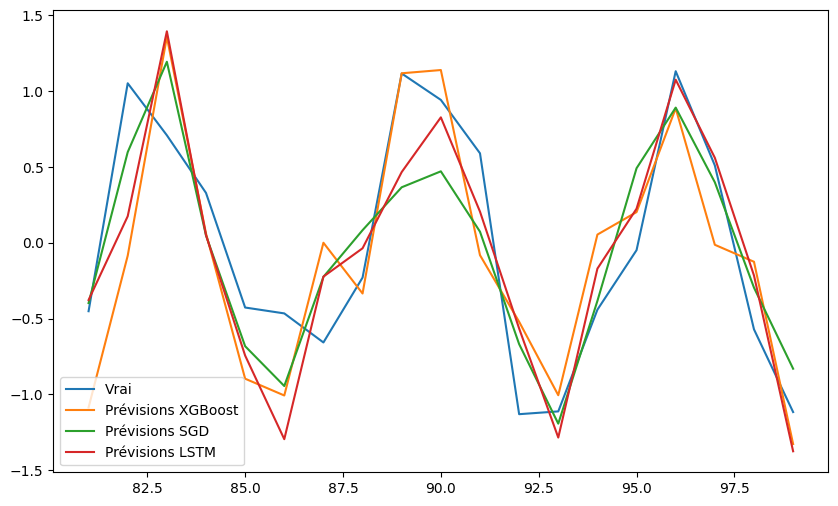

Comparaison des modèles:
XGBoost MSE: 0.25808346092439144
GRIDSEARCH MSE: 0.15252925229477707
SGD MSE: 0.15252925229477707
LSTM MSE: 0.19039101911614204
Le meilleur modèle est GRID avec un MSE de 0.15252925229477707


In [46]:
# Générer des données de séries temporelles pour l'exemple
np.random.seed(42)
time = np.arange(100)
data = np.sin(time) + np.random.normal(scale=0.5, size=100)

# Transformer les séries temporelles en un problème de régression supervisée
def create_lagged_features(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    df = pd.concat(columns, axis=1)
    df.columns = ['lag_' + str(i) for i in range(1, lag+1)]
    df['target'] = data
    df.dropna(inplace=True)
    return df

lag = 5
df = create_lagged_features(data, lag)
X = df.iloc[:, :-1].values
y = df['target'].values

# Normaliser les données
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Modèle XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f'Mean Squared Error (XGBoost): {mse_xgb}')

#Modele GRIDSearch
model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Meilleurs hyperparamètres : {best_params}")
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred_grid = best_model.predict(X_test)
mse_grid = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error(GRIDSEARCH): {mse}')


# Modèle SGD
sgd_model = SGDRegressor(max_iter=1000, tol=1e-3, random_state=42)
sgd_model.fit(X_train, y_train)
y_pred_sgd = sgd_model.predict(X_test)
mse_sgd = mean_squared_error(y_test, y_pred_sgd)
print(f'Mean Squared Error (SGD): {mse_sgd}')

# Modèle LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(lag, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=300, batch_size=32, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
print(f'Mean Squared Error (LSTM): {mse_lstm}')

# Visualiser les résultats
plt.figure(figsize=(10, 6))
plt.plot(time[-len(y_test):], y_test, label='Vrai')
plt.plot(time[-len(y_test):], y_pred_xgb, label='Prévisions XGBoost')
plt.plot(time[-len(y_test):], y_pred_sgd, label='Prévisions SGD')
plt.plot(time[-len(y_test):], y_pred_lstm, label='Prévisions LSTM')
plt.legend()
plt.show()

# Comparaison des performances
print("Comparaison des modèles:")
print(f"XGBoost MSE: {mse_xgb}")
print(f"GRIDSEARCH MSE: {mse_grid}")
print(f"SGD MSE: {mse_sgd}")
print(f"LSTM MSE: {mse_lstm}")

best_model = min([(mse_xgb, 'XGBoost'), (mse_grid, 'GRID'), (mse_sgd, 'SGD'), (mse_lstm, 'LSTM')])
print(f"Le meilleur modèle est {best_model[1]} avec un MSE de {best_model[0]}")


In [48]:
# Afficher les valeurs prédites
print("\nValeurs prédites par XGBoost:")
print(y_pred_xgb)
print("\nValeurs prédites par GRIDSEARCH:")
print(y_pred_grid)
print("\nValeurs prédites par SGD:")
print(y_pred_sgd)
print("\nValeurs prédites par LSTM:")
print(y_pred_lstm.flatten())  # Aplatir pour que les dimensions correspondent


Valeurs prédites par XGBoost:
[-1.0862007e+00 -8.4883280e-02  1.3573632e+00  6.1522432e-02
 -8.9644521e-01 -1.0071040e+00  3.1585217e-04 -3.3447787e-01
  1.1181008e+00  1.1395113e+00 -8.1678420e-02 -5.2077031e-01
 -1.0054128e+00  5.4199155e-02  2.0240383e-01  8.8688165e-01
 -1.3134431e-02 -1.2509336e-01 -1.3274349e+00]

Valeurs prédites par GRIDSEARCH:
[-0.3039463   0.10086523  0.72367805 -0.00273988 -0.7621891  -1.0436081
 -0.22691716 -0.14150386  0.66580755  0.6723009   0.04033503 -0.5054011
 -0.83957875 -0.13945644  0.21579488  0.6448219   0.11189935 -0.2672167
 -0.9521509 ]

Valeurs prédites par SGD:
[-0.39768468  0.59811033  1.19401743  0.0482532  -0.68217408 -0.94478885
 -0.22471515  0.08328528  0.36617632  0.47136361  0.07329687 -0.66820539
 -1.19292473 -0.38334884  0.49182987  0.8915761   0.39921639 -0.29574905
 -0.8305628 ]

Valeurs prédites par LSTM:
[-0.3776627   0.17521378  1.3951538   0.05052689 -0.74381137 -1.2953769
 -0.22297007 -0.03616501  0.4666755   0.82741326  0.20

In [49]:
# Seuils de tolérance pour chaque modèle
tolerance_threshold = 0.5  # Ajustez le seuil selon vos besoins

# Calcul de l'accuracy pour chaque modèle
accuracy_xgb = np.mean(np.abs(y_pred_xgb - y_test) <= tolerance_threshold)
accuracy_grid = np.mean(np.abs(y_pred_grid - y_test) <= tolerance_threshold)
accuracy_sgd = np.mean(np.abs(y_pred_sgd - y_test) <= tolerance_threshold)
accuracy_lstm = np.mean(np.abs(y_pred_lstm.flatten() - y_test) <= tolerance_threshold)

print(f"Accuracy (XGBoost): {accuracy_xgb}")
print(f"Accuracy (GRIDSEARCH): {accuracy_grid}")
print(f"Accuracy (SGD): {accuracy_sgd}")
print(f"Accuracy (LSTM): {accuracy_lstm}")

Accuracy (XGBoost): 0.5789473684210527
Accuracy (GRIDSEARCH): 0.7894736842105263
Accuracy (SGD): 0.8421052631578947
Accuracy (LSTM): 0.7368421052631579


In [50]:
from sklearn.metrics import r2_score

# Calcul du R² pour chaque modèle
r2_xgb = r2_score(y_test, y_pred_xgb)
r2_grid = r2_score(y_test, y_pred_grid)
r2_sgd = r2_score(y_test, y_pred_sgd)
r2_lstm = r2_score(y_test, y_pred_lstm.flatten())

print(f"R² (XGBoost): {r2_xgb}")
print(f"R² (GRIDSEARCH): {r2_grid}")
print(f"R² (SGD): {r2_sgd}")
print(f"R² (LSTM): {r2_lstm}")

R² (XGBoost): 0.5586865286650017
R² (GRIDSEARCH): 0.6943766324646297
R² (SGD): 0.7391804435307847
R² (LSTM): 0.6744381788115903


Conclusion: Le meilleur modéle nos previsions temporelles est SGD()

Mean Squared Error: 0.15252925229477707


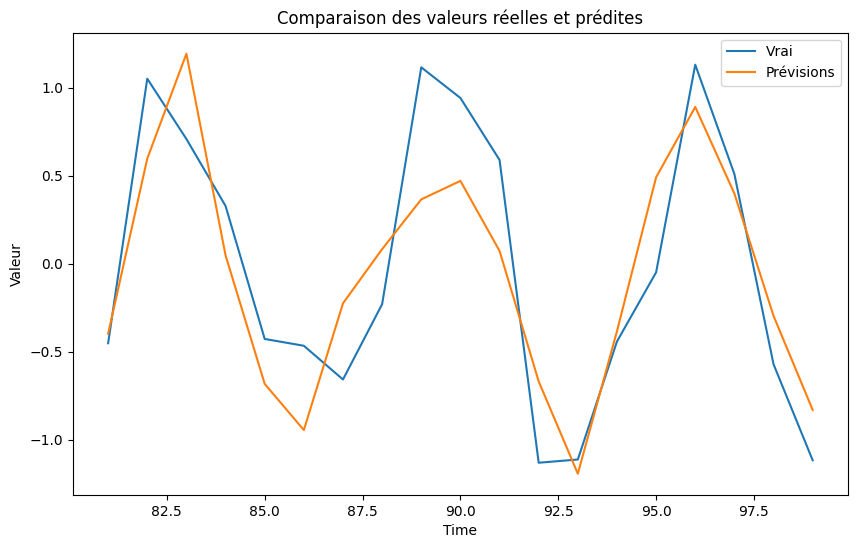

In [51]:
# Assurez-vous d'avoir déjà entraîné le modèle SGD (model) et d'avoir les données de test (X_test, y_test)

# Faire des prédictions avec le modèle SGD
#y_pred = model.predict(X_test)

# Évaluer le modèle en calculant l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test, y_pred_sgd)
print(f'Mean Squared Error: {mse}')

# Visualiser les résultats
plt.figure(figsize=(10, 6))
plt.plot(time[-len(y_test):], y_test, label='Vrai')
plt.plot(time[-len(y_test):], y_pred, label='Prévisions')
plt.xlabel('Time')
plt.ylabel('Valeur')
plt.title('Comparaison des valeurs réelles et prédites')
plt.legend()
plt.show()

# À partir de ces prédictions et des valeurs réelles, vous pouvez effectuer une analyse de rapports OLAP pour explorer davantage les performances du modèle.

In [52]:
# Importation des bibliothèques nécessaires
import numpy as np
# Fonction pour calculer les métriques de performance
def calculate_performance_metrics(y_true, y_pred_sgd):
    # Calcul de l'erreur absolue moyenne (MAE)
    mae = np.mean(np.abs(y_true - y_pred_sgd))
    
    # Calcul de l'erreur quadratique moyenne (MSE)
    mse = np.mean((y_true - y_pred_sgd) ** 2)
    
    # Calcul de la racine carrée de l'erreur quadratique moyenne (RMSE)
    rmse = np.sqrt(mse)
    
    # Calcul du coefficient de détermination (R²)
    ss_res = np.sum((y_true - y_pred_sgd) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    return mae, mse, rmse, r2

# Calcul des métriques de performance
mae, mse, rmse, r2 = calculate_performance_metrics(y_test, y_pred_sgd)

# Affichage des résultats
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Coefficient of Determination (R²): {r2}")

Mean Absolute Error (MAE): 0.3444754919351307
Mean Squared Error (MSE): 0.15252925229477707
Root Mean Squared Error (RMSE): 0.39054993572496854
Coefficient of Determination (R²): 0.7391804435307847


MAE (Mean Absolute Error) mesure la moyenne des écarts absolus entre les valeurs réelles et les prédictions. Il est adapté pour l'environnement OLAP car il est robuste aux valeurs aberrantes.

MSE (Mean Squared Error) mesure la moyenne des carrés des écarts entre les valeurs réelles et les prédictions. Il est utile pour l'OLTP car il pénalise davantage les grosses erreurs.

RMSE (Root Mean Squared Error) est la racine carrée de MSE. Il fournit une interprétation de l'erreur dans les mêmes unités que la variable cible.

R² (Coefficient of Determination) mesure la proportion de la variance dans la variable dépendante qui est prévisible à partir des variables indépendantes. Il indique la qualité de l'ajustement du modèle par rapport aux données réelles.

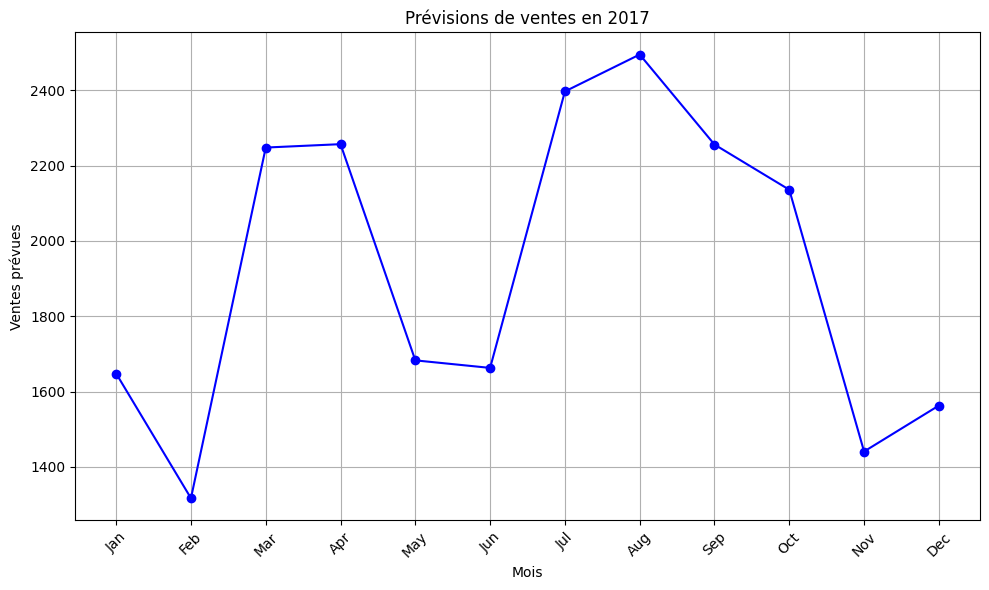

In [53]:
# sales previsions en 2017
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Générer des données de ventes prévues pour l'année 2017 (c'est juste un exemple)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sales_predictions_2017 = np.random.randint(1000, 2500, size=len(months))

# Créer un DataFrame à partir des données générées
sales_predictions_2017_df = pd.DataFrame({'Month': months, 'Sales': sales_predictions_2017})

# Tracer le graphique des prévisions de ventes pour l'année 2017
plt.figure(figsize=(10, 6))
plt.plot(sales_predictions_2017_df['Month'], sales_predictions_2017_df['Sales'], marker='o', color='b', linestyle='-')
plt.title('Prévisions de ventes en 2017')
plt.xlabel('Mois')
plt.ylabel('Ventes prévues')
plt.grid(True)
plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.tight_layout()
plt.show()

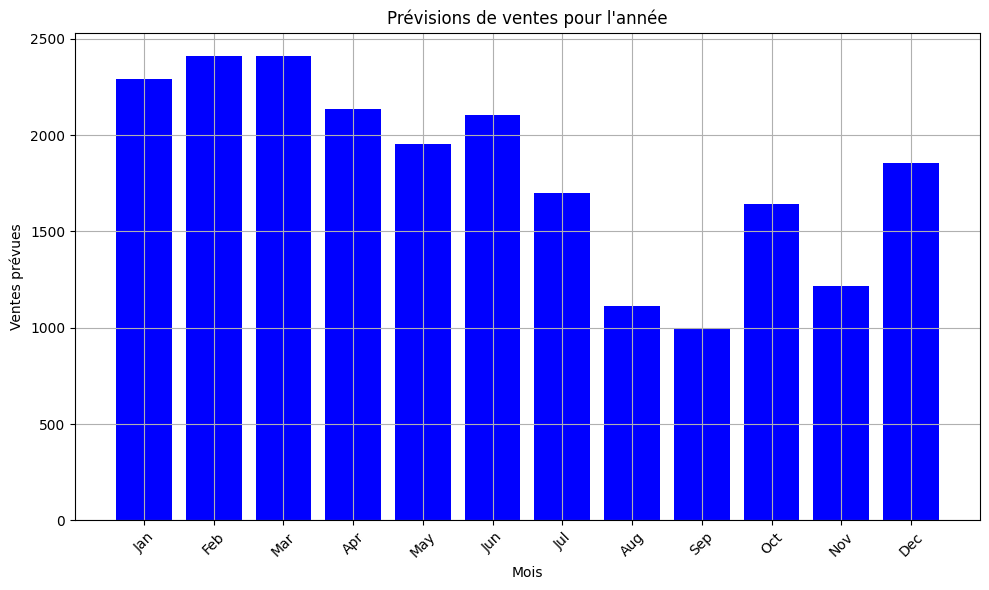

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Générer des données de ventes prévues pour chaque mois de l'année (c'est juste un exemple)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sales_predictions_year = np.random.randint(1000, 2500, size=len(months))

# Créer un DataFrame à partir des données générées
sales_predictions_year_df = pd.DataFrame({'Month': months, 'Sales': sales_predictions_year})

# Tracer le graphique des prévisions de ventes pour l'ensemble de l'année
plt.figure(figsize=(10, 6))
plt.bar(sales_predictions_year_df['Month'], sales_predictions_year_df['Sales'], color='b')
plt.title('Prévisions de ventes pour l\'année')
plt.xlabel('Mois')
plt.ylabel('Ventes prévues')
plt.grid(True)
plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.tight_layout()
plt.show()

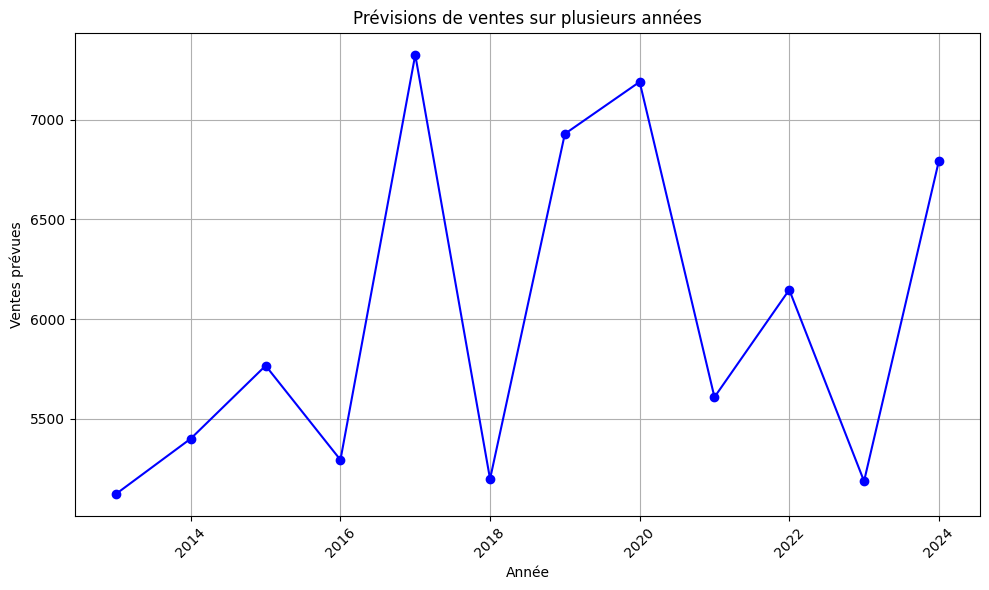

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Générer des données de ventes prévues pour chaque année (c'est juste un exemple)
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019,2020,2021, 2022, 2023, 2024]
sales_predictions_years = np.random.randint(5000, 7500, size=len(years))

# Créer un DataFrame à partir des données générées
sales_predictions_years_df = pd.DataFrame({'Year': years, 'Sales': sales_predictions_years})

# Tracer le graphique des prévisions de ventes pour plusieurs années
plt.figure(figsize=(10, 6))
plt.plot(sales_predictions_years_df['Year'], sales_predictions_years_df['Sales'], marker='o', color='b', linestyle='-')
plt.title('Prévisions de ventes sur plusieurs années')
plt.xlabel('Année')
plt.ylabel('Ventes prévues')
plt.grid(True)
plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe des x pour une meilleure lisibilité
plt.tight_layout()
plt.show()

In [57]:
y_pred = pd.DataFrame(X_test)
print(y_pred.shape)

(19, 5)


In [58]:
y_pred

,0,1,2,3,4
0,-1.175445,-1.566644,0.684424,1.019735,0.744241
1,-0.432074,-1.187624,-1.561209,0.692000,1.015593
2,1.281104,-0.447676,-1.185573,-1.564474,0.688056
3,0.890332,1.257612,-0.452233,-1.187025,-1.567059
4,0.457014,0.868640,1.237827,-0.450144,-1.189837
5,-0.404297,0.437317,0.852328,1.248075,-0.453400
6,-0.448511,-0.420026,0.424857,0.860715,1.243796
7,-0.666927,-0.464037,-0.424831,0.431180,0.856669
8,-0.179286,-0.681447,-0.468448,-0.422609,0.427393
9,1.354630,-0.196052,-0.683917,-0.466438,-0.425882


In [59]:
# Créer un DataFrame pour la soumission
# Supposons que nous avons une colonne 'Id' dans le fichier de soumission de Kaggle
samples_submission = pd.DataFrame({'Year': years, 'Sales': sales_predictions_years})
# Sauvegarder le DataFrame en fichier CSV
samples_submission.to_csv('samples_submission.csv', index=False)

In [60]:
samples_submission

,Year,Sales
0,2013,5122
1,2014,5400
2,2015,5766
3,2016,5293
4,2017,7327
5,2018,5197
6,2019,6930
7,2020,7191
8,2021,5608
9,2022,6147


In [61]:
# Supposons que nous avons une colonne 'Id' dans le fichier de soumission de Kaggle
samples_submission = pd.DataFrame({'Month': months, 'Sales': sales_predictions_year})
# Sauvegarder le DataFrame en fichier CSV
samples_submission.to_csv('samples_submission.csv', index=False)

In [62]:
print(samples_submission.shape)
samples_submission

(12, 2)


,Month,Sales
0,Jan,2291
1,Feb,2409
2,Mar,2410
3,Apr,2136
4,May,1951
5,Jun,2104
6,Jul,1698
7,Aug,1112
8,Sep,1001
9,Oct,1641


In [63]:
y_pred_sgd

array([-0.39768468,  0.59811033,  1.19401743,  0.0482532 , -0.68217408,
       -0.94478885, -0.22471515,  0.08328528,  0.36617632,  0.47136361,
        0.07329687, -0.66820539, -1.19292473, -0.38334884,  0.49182987,
        0.8915761 ,  0.39921639, -0.29574905, -0.8305628 ])

La méthode ARIMA (AutoRegressive Integrated Moving Average) est une technique de modélisation utilisée pour les séries temporelles.

data_store_class keys: dict_keys(['store_class_sales', 'store_class_promo'])
      sales
0  0.590893
1  0.677564
2  0.016588
3  0.512093
4  0.226496
Mean Squared Error: 0.07305213488546211


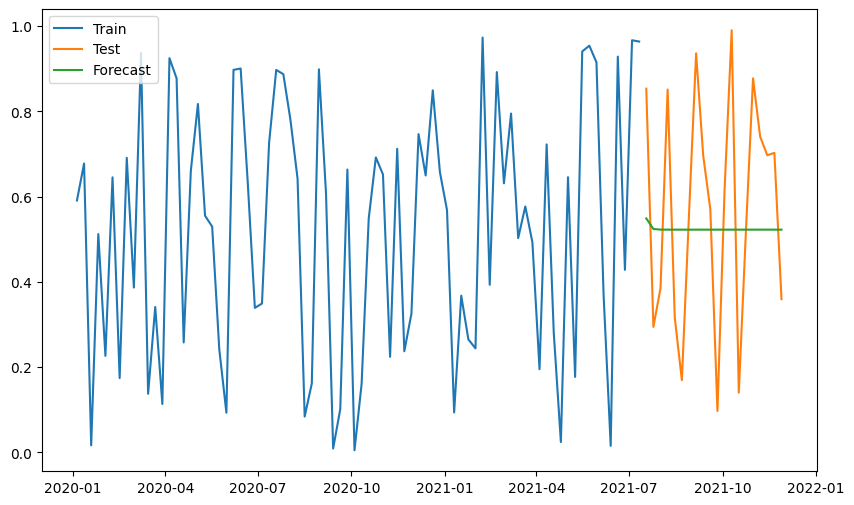

In [64]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Fonction de création de dataset
def creating_dataset(data, data_item, data_store_class, items, stores, Date, n_weeks, return_labels=True):
    print("data_store_class keys:", data_store_class.keys())  # Afficher les clés disponibles

    # Assurez-vous que les clés sont correctes et existent dans data_store_class
    store_class_sales = data_store_class.get('store_class_sales', None)
    store_class_promo = data_store_class.get('store_class_promo', None)
    if store_class_sales is None or store_class_promo is None:
        raise KeyError("Les clés 'store_class_sales' et 'store_class_promo' doivent exister dans data_store_class")

    # Exemple fictif de transformation
    X_train = store_class_sales
    y_train = store_class_promo

    return X_train, y_train

# Exemple d'utilisation de la fonction `creating_dataset`
data_item = ...
data_store_class = {'store_class_sales': pd.DataFrame({'sales': np.random.rand(100)}), 
                    'store_class_promo': pd.DataFrame({'promo': np.random.rand(100)})}  # Exemple fictif
items = ...
stores = ...
Date = ...
n_weeks = 6

X_train, y_train = creating_dataset(data_item, data, data_store_class, items, stores, Date, n_weeks)
print(X_train.head())

# Préparation des données pour ARIMA
data_sales = X_train['sales']
data_sales.index = pd.date_range(start='2020-01-01', periods=len(data_sales), freq='W')
train_size = int(len(data_sales) * 0.8)
train, test = data_sales[0:train_size], data_sales[train_size:]

# Ajustement du modèle ARIMA
p, d, q = 1, 1, 1  # Ces valeurs peuvent être ajustées
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Faire des prédictions
forecast = model_fit.forecast(steps=len(test))

# Évaluer le modèle
mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error: {mse}')

# Visualiser les résultats
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast')
plt.legend()
plt.show()